In [173]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.ticker as ticker

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras

In [9]:
# fetch data
# !cd data && kaggle datasets download sudalairajkumar/novel-corona-virus-2019-dataset && unzip novel-corona-virus-2019-dataset.zip && rm novel-corona-virus-2019-dataset.zip

In [10]:
data = pd.read_csv('data/covid_19_data.csv')
data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [11]:
world = data.groupby(['ObservationDate']).sum()

active = lambda confirmed, deaths, recovered: confirmed - (deaths + recovered)

world.loc[:, 'Active'] = world.apply(lambda x: active(x['Confirmed'], x['Deaths'], x['Recovered']), axis=1)
world.head()

,SNo,Confirmed,Deaths,Recovered,Active
ObservationDate,,,,,
01/22/2020,741,555.0,17.0,28.0,510.0
01/23/2020,2829,653.0,18.0,30.0,605.0
01/24/2020,4305,941.0,26.0,36.0,879.0
01/25/2020,6490,1438.0,42.0,39.0,1357.0
01/26/2020,9071,2118.0,56.0,52.0,2010.0


In [65]:
def make_plot(x, y, title, marker='.', grid=True, alpha=0.3, 
              figsize=[7, 5], xlabel='Date', ylabel='Count', xmultiples=2):
    fig, ax = plt.subplots(figsize=figsize)

    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)  

    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.xticks(rotation=90,fontsize=10)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(xmultiples))

    plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                    labelbottom=True, left=False, right=False, labelleft=True)  
    plt.title(title, fontsize=18)
    plt.grid(grid, alpha=alpha)

    plt.scatter(x, y, marker=marker)
    plt.show()
    
def make_multi_plot(datasets, title, marker='.', grid=True, alpha=0.3, 
              figsize=[7, 5], xlabel='Date', ylabel='Count', xmultiples=2):
    fig, ax = plt.subplots(figsize=figsize)

    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)  

    plt.xlabel(xlabel,fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.xticks(rotation=90,fontsize=10)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(xmultiples))

    plt.tick_params(axis="both", which="both", bottom=False, top=False,    
                    labelbottom=True, left=False, right=False, labelleft=True)  
    plt.title(title, fontsize=18)
    plt.grid(grid, alpha=alpha)
    
    for dataset in datasets:
        plt.scatter(dataset[0], dataset[1], label=dataset[2], marker=marker)
    
    plt.legend()
    plt.show()

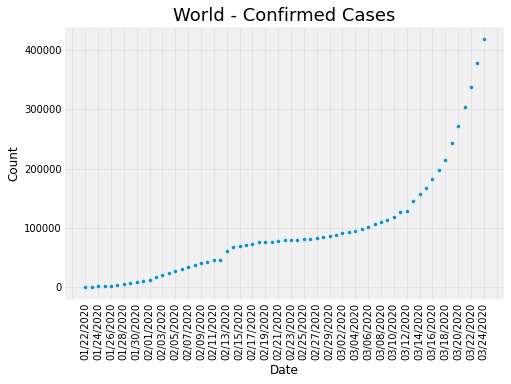

In [132]:
%matplotlib inline
make_plot(world.index, world['Confirmed'], 'World - Confirmed Cases')

In [133]:
future = np.arange(30).reshape(-1, 1) + 1 + len(world.index)

X_confirmed = np.arange(len(world.index)).reshape(-1, 1)
y_confirmed = world['Confirmed'].to_numpy()

X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(X_confirmed, y_confirmed, test_size=0.2, random_state=42)

In [134]:
# param_distributions = {
#     'C': [0.1, 1],
#     'gamma' : [0.01, 0.1],
#     'epsilon': [0.1, 1], 
#     'degree': [4, 5, 6]
# }

# svr_ = RandomizedSearchCV(SVR(kernel='poly'),
#                    param_distributions=param_distributions, cv=3, 
#                    scoring='neg_mean_squared_error',
#                    n_jobs=-1,
#                    verbose=True)

# svr_.fit(X_train_confirmed, y_train_confirmed)
# best_estimator = svr_.best_estimator_
# best_params = svr_.best_params_

In [135]:
svr_confirmed = SVR(kernel='poly', C=0.1, gamma=0.01, epsilon=0.1, degree=6)
svr_confirmed.fit(X_train_confirmed, y_train_confirmed)
svr_confirmed.score(X_test_confirmed, y_test_confirmed)

0.9551147552425917

In [136]:
y_confirmed_pred = svr_confirmed.predict(X_confirmed)
future_confirmed_pred = svr_confirmed.predict(future)

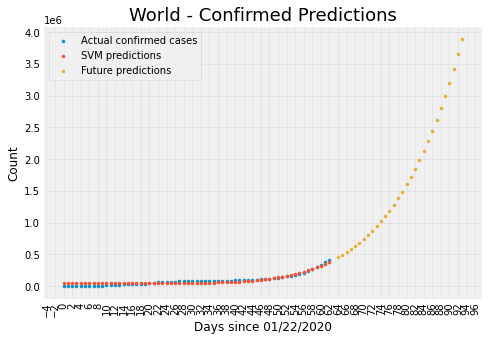

In [149]:
%matplotlib inline
make_multi_plot([
    (X_confirmed, y_confirmed, 'Actual confirmed cases'),
    (X_confirmed, y_confirmed_pred, 'SVM predictions'),
    (future, future_confirmed_pred, 'Future predictions')], 'World - Confirmed Predictions', xlabel=f'Days since {min(world.index)}')

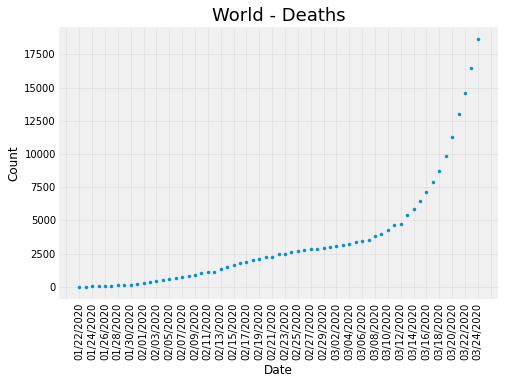

In [73]:
%matplotlib inline
make_plot(world.index, world['Deaths'], 'World - Deaths')

In [74]:
X_deaths = np.arange(len(world.index)).reshape(-1, 1)
y_deaths = world['Deaths'].to_numpy()

X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(X_deaths, y_deaths, test_size=0.2, random_state=42)

In [75]:
# param_distributions = {
#     'C': [0.1, 1],
#     'gamma' : [0.01, 0.1],
#     'epsilon': [0.1, 1], 
#     'degree': [4, 5, 6]
# }

# svr_ = RandomizedSearchCV(SVR(kernel='poly'),
#                    param_distributions=param_distributions, cv=3, 
#                    scoring='neg_mean_squared_error',
#                    n_jobs=-1,
#                    verbose=True)

# svr_.fit(X_train_deaths, y_train_deaths)
# best_estimator = svr_.best_estimator_
# best_estimator.score(X_test_deaths, y_test_deaths)

In [76]:
svr_deaths = SVR(kernel='poly', C=0.1, gamma=0.01, epsilon=0.1, degree=6)
svr_deaths.fit(X_train_deaths, y_train_deaths)
svr_deaths.score(X_test_deaths, y_test_deaths)

0.9731001524329052

In [77]:
y_deaths_pred = svr_deaths.predict(X_deaths)
future_deaths_pred = svr_deaths.predict(future)

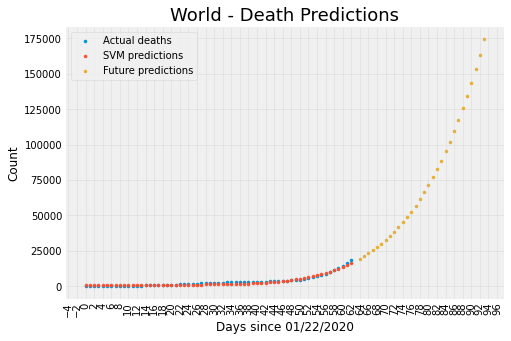

In [150]:
%matplotlib inline
make_multi_plot([
    (X_deaths, y_deaths, 'Actual deaths'),
    (X_deaths, y_deaths_pred, 'SVM predictions'),
    (future, future_deaths_pred, 'Future predictions')], 'World - Death Predictions', xlabel=f'Days since {min(world.index)}')

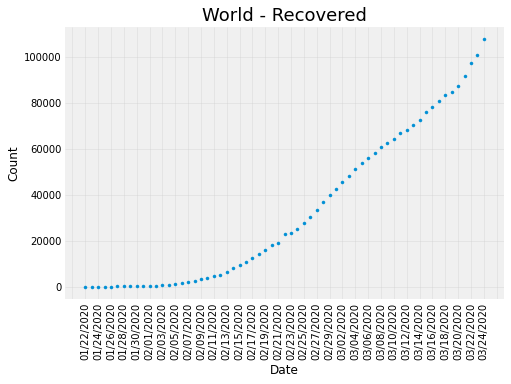

In [79]:
%matplotlib inline
make_plot(world.index, world['Recovered'], 'World - Recovered')

In [81]:
X_recovered = np.arange(len(world.index)).reshape(-1, 1)
y_recovered = world['Recovered'].to_numpy()

X_train_recovered, X_test_recovered, y_train_recovered, y_test_recovered = train_test_split(X_recovered, y_recovered, test_size=0.2, random_state=42)

In [75]:
# param_distributions = {
#     'C': [0.1, 1],
#     'gamma' : [0.01, 0.1],
#     'epsilon': [0.1, 1], 
#     'degree': [4, 5, 6]
# }

# svr_ = RandomizedSearchCV(SVR(kernel='poly'),
#                    param_distributions=param_distributions, cv=3, 
#                    scoring='neg_mean_squared_error',
#                    n_jobs=-1,
#                    verbose=True)

# svr_.fit(X_train_deaths, y_train_deaths)
# best_estimator = svr_.best_estimator_
# best_estimator.score(X_test_deaths, y_test_deaths)

In [111]:
svr_recovered = SVR(kernel='poly', C=0.01, gamma=0.01, epsilon=0.1, degree=4)
svr_recovered.fit(X_train_recovered, y_train_recovered)
svr_recovered.score(X_test_recovered, y_test_recovered)

0.9232967984561395

In [104]:
y_recovered_pred = svr_recovered.predict(X_recovered)
future_recovered_pred = svr_recovered.predict(future)

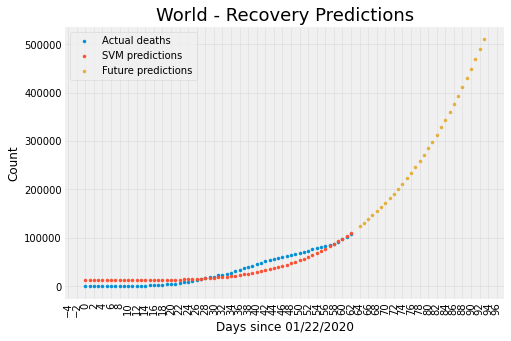

In [151]:
%matplotlib inline
make_multi_plot([
    (X_recovered, y_recovered, 'Actual deaths'),
    (X_recovered, y_recovered_pred, 'SVM predictions'),
    (future, future_recovered_pred, 'Future predictions')], 'World - Recovery Predictions', xlabel=f'Days since {min(world.index)}')

In [176]:
X = np.append(np.arange(len(world.index)), future)
confirmed_pred = np.append(y_confirmed_pred, future_confirmed_pred)
deaths_pred = np.append(y_deaths_pred, future_deaths_pred)
recovered_pred = np.append(y_recovered_pred, future_recovered_pred)

active_true = y_confirmed - (y_deaths + y_recovered)
active_pred = confirmed_pred - (deaths_pred + recovered_pred)

r2_score(active_true, active_pred[:len(world.index)])

0.8893620626905554

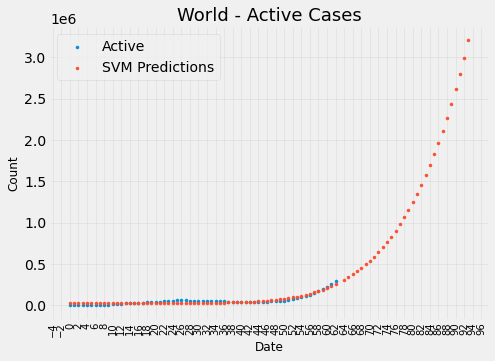

In [177]:
make_multi_plot([
    (np.arange(len(world.index)), active_true, 'Active'),
    (X, active_pred, 'SVM Predictions')
], 'World - Active Cases')



In [155]:
country = data.groupby(['Country/Region', 'ObservationDate']).sum()
country.head()

SNo  Confirmed  Deaths  Recovered
Country/Region  ObservationDate                                    
 Azerbaijan     02/28/2020       2664        1.0     0.0        0.0
('St. Martin',) 03/10/2020       4675        2.0     0.0        0.0
Afghanistan     02/24/2020       2259        1.0     0.0        0.0
                02/25/2020       2352        1.0     0.0        0.0
                02/26/2020       2453        1.0     0.0        0.0

In [156]:
china = country.loc['Mainland China']
china.head()

,SNo,Confirmed,Deaths,Recovered
ObservationDate,,,,
01/22/2020,535,547.0,17.0,28.0
01/23/2020,1713,639.0,18.0,30.0
01/24/2020,3004,916.0,26.0,36.0
01/25/2020,4224,1399.0,42.0,39.0
01/26/2020,5548,2062.0,56.0,49.0


In [157]:
china.loc[:, 'Active'] = china.apply(lambda x: active(x['Confirmed'], x['Deaths'], x['Recovered']), axis=1)

/home/anthony/projects/corona/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/anthony/projects/corona/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


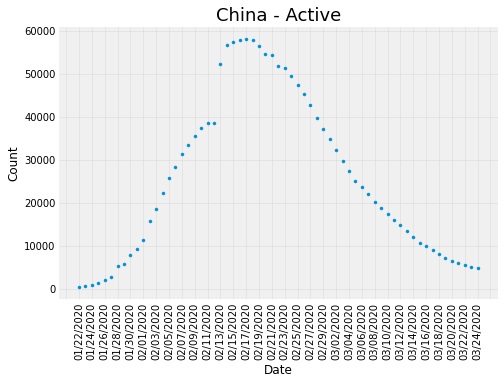

In [167]:
%matplotlib inline
make_plot(china.index, china['Active'], 'China - Active')

In [163]:
# def PolynomialRegression(degree=2, **kwargs):
#     return Pipeline([
#         ('std', StandardScaler()),
#         ('poly', PolynomialFeatures(degree)),
#         ('lin_reg', LinearRegression(**kwargs))
#     ])

# poly_reg = PolynomialRegression()

# param_grid = param_grid = {
#     'poly__degree': np.arange(10), 
#     'lin_reg__fit_intercept': [True, False], 
#     'lin_reg__normalize': [True, False]
# }

# grid_search = GridSearchCV(poly_reg, param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5)
# grid_search.fit(X_train, y_train)

In [164]:
us = country.loc['US']
us.head()

,SNo,Confirmed,Deaths,Recovered
ObservationDate,,,,
01/22/2020,32,1.0,0.0,0.0
01/23/2020,70,1.0,0.0,0.0
01/24/2020,237,2.0,0.0,0.0
01/25/2020,319,2.0,0.0,0.0
01/26/2020,818,5.0,0.0,0.0


In [165]:
us.loc[:, 'Active'] = us.apply(lambda x: active(x['Confirmed'], x['Deaths'], x['Recovered']), axis=1)

/home/anthony/projects/corona/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/anthony/projects/corona/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


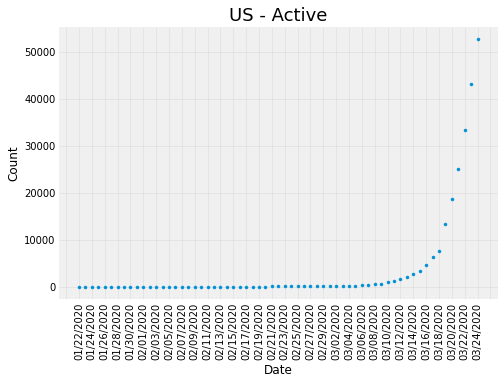

In [166]:
make_plot(us.index, us['Active'], 'US - Active')